- Import Libraries

In [ ]:
import os
import warnings
import numpy as np
import scipy.io.wavfile as wav
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from python_speech_features import mfcc, logfbank
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

- Suppress warnings

In [ ]:
warnings.filterwarnings("ignore")

- Directory containing the sound clips

In [3]:
directory = 'C:\\Development\\@labs\\sonispect\\data\\raw\\sound_clips\\'

# :: Check if the directory exists
if not os.path.exists(directory):
    print("The directory does not exist")
    exit()

- Initialize empty lists for the features and labels

In [4]:
features = []
labels = []

- Process each folder and file in the directory

In [5]:
for i, folder in enumerate(os.listdir(directory)):
    print(f"PROCESSING FOLDER: {folder}")
    
    if i == 10:  # :: Process only the first 10 folders
        break
    
    for file in os.listdir(directory + folder):
        file_path = os.path.join(directory + folder, file)
        print(f"PROCESSING FILE: {file_path}")
        
        if os.path.isfile(file_path) and file_path.endswith(".wav"):
            try:
                # :: Read the audio file
                (rate, sig) = wav.read(file_path)
                
                # :: Extract MFCC features
                mfcc_feat = mfcc(
                    sig,
                    rate,
                    winlen=0.025,
                    winstep=0.01,
                    numcep=13,
                    nfilt=26,
                    nfft=1024,
                    appendEnergy=True,
                )
                
                # :: Calculate covariance and mean matrix
                covariance = np.cov(np.matrix.transpose(mfcc_feat))
                mean_matrix = mfcc_feat.mean(0)
                
                # :: Append features and labels
                features.append(mean_matrix)
                labels.append(i)
                
            except Exception as e:
                print(f"PROCESSING ERROR at {file_path}:\n{e}")
                continue

print(f"\nPROCESSED: {len(features)} instances")

PROCESSING FOLDER: blues
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00000.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00001.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00002.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00003.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00004.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00005.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00006.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00007.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00008.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_clips\blues\blues.00009.wav
PROCESSING FILE: C:\Development\@labs\sonispect\data\raw\sound_cl

- Convert lists to numpy arrays

In [6]:
features = np.array(features)
labels = np.array(labels)

- Distribution of MFCC Features

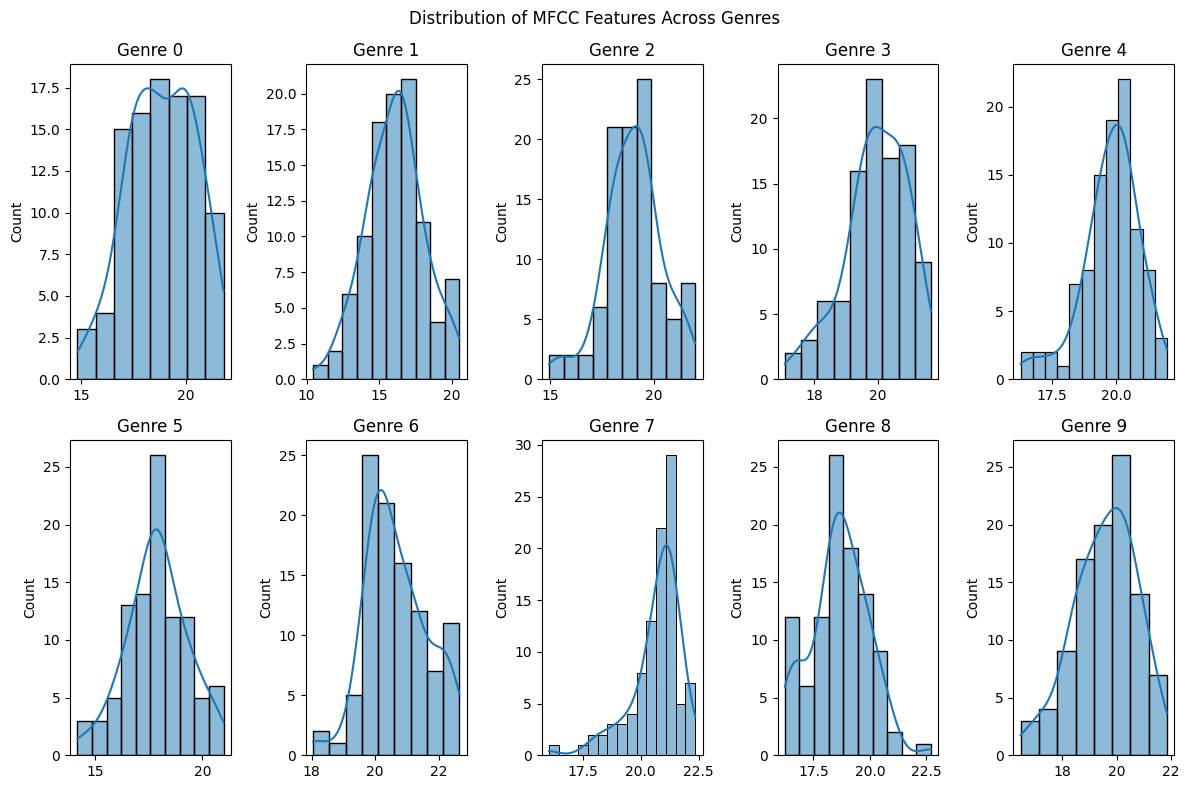

In [7]:
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    sns.histplot(features[labels == i][:, 0], kde=True, label=f'Genre {i}')
    plt.title(f'Genre {i}')
plt.suptitle('Distribution of MFCC Features Across Genres')
plt.tight_layout()
plt.show()

- Encode labels to ensure they are contiguous and start from 0

In [8]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

- Normalize the featurs

In [ ]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

- Split the dataset into training and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42, stratify=labels
)

- Train the XGBoost model

In [18]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=10,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, ...)

- Make predictions, calculate accuracy

In [30]:
# :: Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# :: Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)

# :: Print the accuracy of the XGBoost model
print("ACCURACY: {:.2f}%".format(accuracy * 100))

ACCURACY: 56.06%


- Hyperparameter Tuning

In [32]:
param_grid = {
  'n_estimators': [50, 100, 200],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.01, 0.1, 0.2],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

# :: Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=10)

# :: Initialize Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=1)

# :: Train Grid Search
grid_search.fit(X_train, y_train)

# :: Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsampl

In [33]:
# :: Train the model with the generated best parameters
bp_xgb_model = xgb.XGBClassifier(**best_params)
bp_xgb_model.fit(X_train, y_train)

# :: Evaluate the model
y_pred = bp_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 56.36%


- Feature Engineering

In [ ]:
# :: Initialize empty lists for the features and labels
features = []
labels = []

# :: Extract additional features
def extract_features(file_path):
  (rate, sig) = wav.read(file_path)
  mfcc_feat = mfcc(sig, rate, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=1024)
  logfbank_feat = logfbank(sig, rate, winlen=0.025, winstep=0.01, nfilt=26, nfft=1024)
  return np.hstack((mfcc_feat, logfbank_feat))


# :: Update feature extraction loop
for i, folder in enumerate(os.listdir(directory)):
    for file in os.listdir(directory + folder):
        file_path = os.path.join(directory + folder, file)
        if os.path.isfile(file_path) and file_path.endswith(".wav"):
            try:
                features.append(extract_features(file_path))
                labels.append(folder)
            except Exception as e:
                print(f"PROCESSING ERROR at {file_path}: {e}")

print(f"\nPROCESSED: {len(features)} instances")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (999,) + inhomogeneous part.

- Pad features to ensure they all have the same length

In [48]:
max_shape = np.max([feature.shape for feature in features], axis=0)
padded_features = np.array([np.pad(feature, ((0, max_shape[0] - feature.shape[0]), (0, max_shape[1] - feature.shape[1])), mode='constant') for feature in features])

- Convert labels to a NumPy array

In [49]:
labels = np.array(labels)

- Encode the labels

In [50]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

- Normalize the features

In [51]:
scaler = StandardScaler()
features = scaler.fit_transform(padded_features.reshape(len(padded_features), -1))

- Split the dataset into training and test sets with stratification

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42, stratify=labels
)

- Use the Hyperparameter Tuned Model

In [53]:
# :: Train the model with the generated best parameters
bp_xgb_model = xgb.XGBClassifier(**best_params)
bp_xgb_model.fit(X_train, y_train)

# :: Evaluate the model
y_pred = bp_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 60.61%
